In [ ]:
# !mkdir -p ~/work/semantic_segmentation/data
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
# !unzip data_semantics.zip -d ~/work/semantic_segmentation/data/


--2025-09-12 05:47:28--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.102, 3.5.136.47, 52.219.171.37, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  12.9MB/s    in 27s     

2025-09-12 05:47:56 (11.7 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]

Archive:  data_semantics.zip
   creating: /home/jovyan/work/semantic_segmentation/data/testing/
   creating: /home/jovyan/work/semantic_segmentation/data/testing/image_2/
  inflating: /home/jovyan/work/semantic_segmentation/data/testing/image_2/000000_10.png  
  inflating: /home/jovyan/work/semantic_segmentation/data/testing/image_2/000001_10.png  
  inflating: /home/jovyan/work/semantic_seg

In [ ]:
# !pip install albumentations

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached pydantic-2.11.9-py3-none-any.whl.metadata (68 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached stringzilla-4.0.8.tar.gz (468 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached simsimd-6.5.3-cp313-cp313-win_amd64.whl.metadata (71 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp313-cp313-win_amd64.whl.metadata (6.9 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cac

In [2]:
#필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import torch.nn as nn
import torch.optim as optim

print('=3')

=3


albumentations이 안깔리는 문제가 있었다.
확인해보니 내 컴퓨터에서 하기위해서는 C++에 환경을 불러올 수 있어야 하는데 C++을 안쓰니 못한것
vs studio를 2022로 업그래이드 하면서 해결함.

In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize


In [5]:

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            size=(224, 224),
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                    Resize(
                        width=224,
                        height=224
                        )
                    ])

In [11]:
data_dir = os.path.join(os.getenv("HOME"), "Segmentation/semantic_segmentation/data/training")
DATA_PATH  = data_dir
print(DATA_PATH)

D:\project\Aiffel\Segmentation/semantic_segmentation/data/training


C:\Users\kicha\AppData\Local\Temp\ipykernel_9592\3497579101.py:5: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


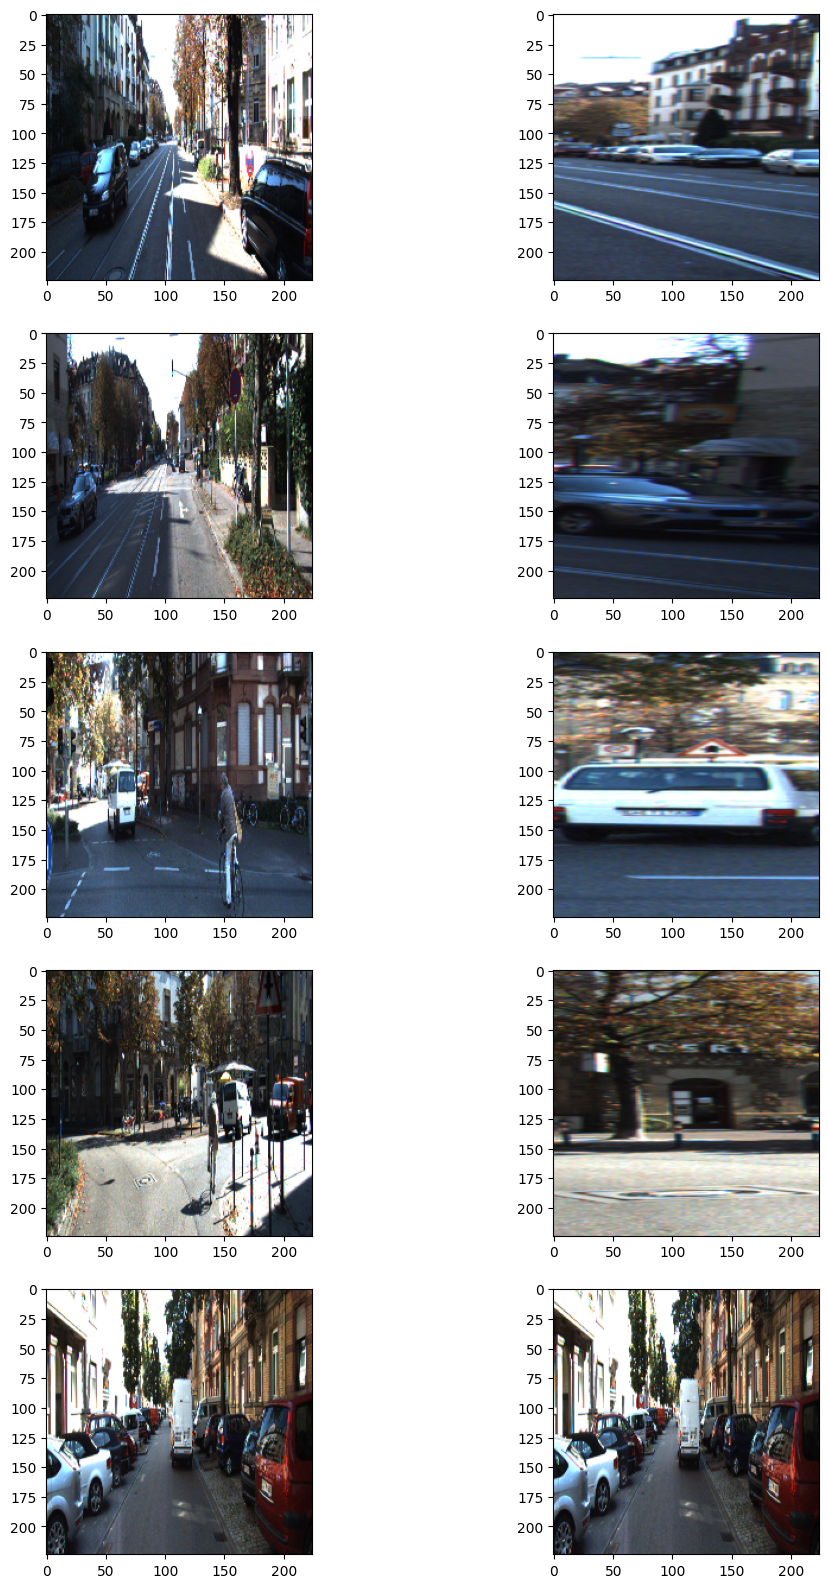

In [28]:
# data_dir = os.path.join(os.getenv("HOME"), "Segmentation/semantic_segmentation/data/training")
data_dir = "./semantic_segmentation/data/training"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(data_dir, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [29]:
from torch.utils.data import Dataset

class KittiDataset(Dataset):
    '''
    KittiDataset은 PyTorch의 Dataset을 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Dataset을 커스텀하여 사용합니다.
    '''
    def __init__(self,
                dir_path,
                img_size=(224, 224, 3),
                output_size=(224, 224),
                is_train=True,
                augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Dataset이 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해 kitti dataset의 경로에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Dataset의 length로서 전체 dataset 크기를 반환합니다.
        return len(self.data)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        # 특정 라벨을 이진 마스크로 변환
        _output = (_output == 7).astype(np.uint8) * 1

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0  # Normalize
            _output = augmented["mask"]

        # 📌 target 차원 확장 (H, W) → (1, H, W)
        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),  # (H, W, C) → (C, H, W)
            torch.tensor(_output, dtype=torch.float32)  # (1, H, W) 형식 유지
        )

    def shuffle_data(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 데이터를 random shuffle합니다.
        if self.is_train:
            np.random.shuffle(self.data)

In [30]:
from torch.utils.data import DataLoader

# Augmentation 설정
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_dataset = KittiDataset(
    data_dir,
    augmentation=augmentation,
    is_train=True
)

test_dataset = KittiDataset(
    data_dir,
    augmentation=test_preproc,
    is_train=False
)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\kicha\AppData\Local\Temp\ipykernel_9592\3497579101.py:5: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop


In [10]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Expanding Path (Decoder)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """2개의 Conv Layer로 이루어진 블록"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        c4 = self.enc4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.bottleneck(p4)
        c5 = self.dropout(c5)

        # Decoder
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.dec6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.dec7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.dec8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.dec9(u9)

        # Output
        output = torch.sigmoid(self.final(c9))
        return output

In [16]:
%%time

# 모델 저장 경로
model_path = "./semantic_segmentation/seg_model_unet.pth"

# 모델 생성
model = UNet(input_channels=3, output_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 데이터로더 준비
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # 타겟을 float 타입으로 변환
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# 모델 저장
torch.save(model.state_dict(), model_path)

Epoch 1/100, Loss: 0.7086472294547341
Epoch 2/100, Loss: 0.6660946770147844
Epoch 3/100, Loss: 0.5654269104654138
Epoch 4/100, Loss: 0.5274722088466991
Epoch 5/100, Loss: 0.434513582424684
Epoch 6/100, Loss: 0.3409090909090909
Epoch 7/100, Loss: 0.30387215451760724
Epoch 8/100, Loss: 0.2920352112163197
Epoch 9/100, Loss: 0.26850813085382635
Epoch 10/100, Loss: 0.2464041682806882
Epoch 11/100, Loss: 0.22828087210655212
Epoch 12/100, Loss: 0.22855203395540064
Epoch 13/100, Loss: 0.22337160462682898
Epoch 14/100, Loss: 0.2287741547281092
Epoch 15/100, Loss: 0.21472769027406519
Epoch 16/100, Loss: 0.21852119944312356
Epoch 17/100, Loss: 0.22721714865077625
Epoch 18/100, Loss: 0.20932104235345667
Epoch 19/100, Loss: 0.22505219280719757
Epoch 20/100, Loss: 0.18946606327186932
Epoch 21/100, Loss: 0.17999767037955197
Epoch 22/100, Loss: 0.19392715123566714
Epoch 23/100, Loss: 0.19532079926945947
Epoch 24/100, Loss: 0.18730308657342737
Epoch 25/100, Loss: 0.18004584583369168
Epoch 26/100, Loss:

In [12]:
# 모델 저장 경로
model_path = "./semantic_segmentation/seg_model_unet.pth"

model = UNet(input_channels=3, output_channels=1)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 평가 모드로 전환

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [13]:
import matplotlib.pyplot as plt

def get_output(model, preproc, image_path, output_path):
    # 원본 이미지 로드
    origin_img = imread(image_path)
    data = {"image": origin_img}

    # 전처리 적용
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

    # 모델 추론 (inference)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 시그모이드 활성화 후 임계값(0.5) 적용하여 바이너리 마스크 생성
    output = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255   #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)

    # 배경과 결합하여 시각화 (Overlay)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, output, alpha=0.5)

    # 변환된 이미지 저장
    blended.save(output_path)

    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    # blended.show()
    return blended

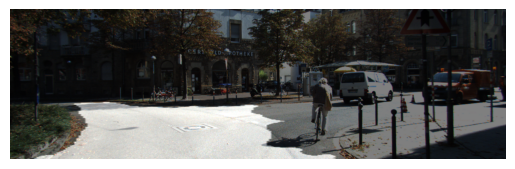

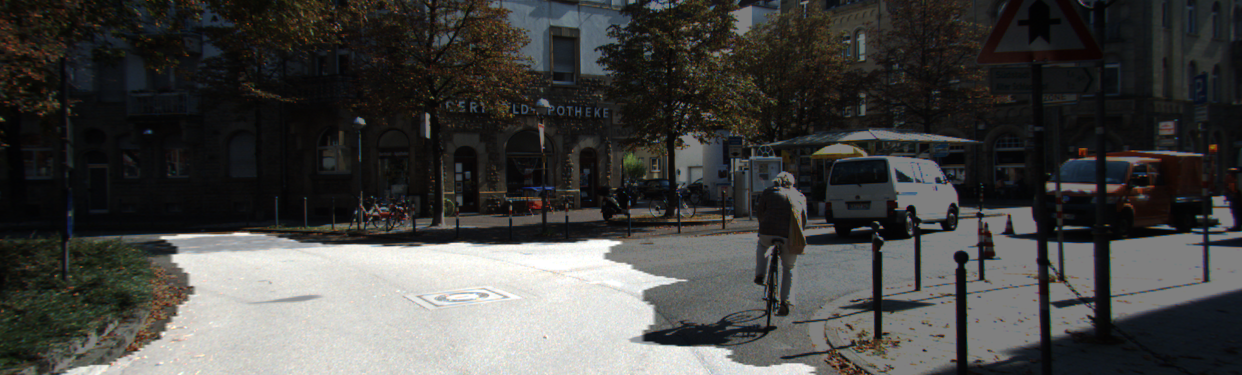

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 3   # i값을 바꾸면 테스트용 파일이 달라집니다.
dir_path = "./semantic_segmentation/data/training"

get_output(
     model,
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png'
 )

In [15]:
def calculate_iou_score(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant', preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    union = np.logical_or(target, prediction).sum() # intersection을 구하는 코드를 작성해주세요.
    iou_score = intersection / (union + 1e-7)  # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    print(f"IoU : {iou_score:.6f}")
    return iou_score

In [16]:
def get_output(model, preproc, image_path, output_path, label_path=None):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    prediction = (output[0].squeeze().numpy() > 0.5).astype(np.uint8) * 255
    prediction = Image.fromarray(prediction).convert('L')

    background = Image.fromarray(origin_img).convert('RGBA')
    prediction_resized = prediction.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    blended = Image.blend(background, prediction_resized, alpha=0.5)

    blended.save(output_path)
    # PIL 객체를 numpy로 변환
    img_np = np.array(blended)

    # 시각화
    plt.imshow(img_np)
    plt.axis('off')  # 축 제거 (옵션)
    plt.show()

    target = None
    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)["image"]
        target = (label_processed == 7).astype(np.uint8) * 1

    return blended, np.array(prediction), target

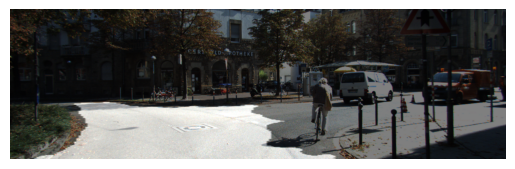

IoU : 0.652988


np.float64(0.6529877609732452)

In [17]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 3    # i값을 바꾸면 테스트용 파일이 달라집니다.
output, prediction, target = get_output(
    model,
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target, prediction)

# U++를 만드는 프로젝트를 시작해 보자


In [1]:
import torch
import numpy as np
import PIL
import skimage
import albumentations

print(torch.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

c:\Users\kicha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.7.1+cu118
2.2.6
11.3.0
0.25.2
2.0.8


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# U-Net++ 모델의 아키텍처 정의
# U-Net++의 핵심인 중첩된 Skip-Path와 Deep Supervision을 구현하는 UNetPlusPlus 클래스를 작성
# 먼저, U-Net++ 아키텍처에 반복적으로 사용될 기본 컨볼루션 블록을 VGGBlock으로 정의하고, 
# 이를 조합하여 전체 UNetPlusPlus 모델을 구축
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out
    
class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False):
        super().__init__()

        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return torch.sigmoid(output)

### 주요 변경 및 특징
   * VGGBlock: U-Net++ 논문에서 제안된 기본 블록으로, 두 개의 Conv-BN-ReLU 레이어로 구성됩니다. 기존 U-Net
     구현과 유사하여 코드의 일관성을 유지합니다.
  이제 이 UNetPlusPlus 클래스를 사용하여 모델을 생성하고 훈련을 진행할 수 있습니다.

In [19]:
%%time

# 모델 저장 경로
model_path_plus_plus = "./semantic_segmentation/seg_model_unet_plus_plus.pth"

# U-Net++ 모델 생성
# deep_supervision은 False로 설정하여 U-Net과 동일한 조건으로 비교
model_plus_plus = UNetPlusPlus(num_classes=1, input_channels=3, deep_supervision=False) # True로 설정하면 Deep Supervision 적용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_plus_plus.to(device) 

# 손실 함수 및 옵티마이저 설정 (U-Net과 동일)
criterion = torch.nn.BCELoss()  #이진 크로스 엔트로피 손실 함수
optimizer = optim.Adam(model_plus_plus.parameters(), lr=1e-4)   # Adam 옵티마이저 사용 

# 데이터로더 준비 (기존과 동일)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model_plus_plus.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model_plus_plus(inputs)
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# 모델 저장
torch.save(model_plus_plus.state_dict(), model_path_plus_plus)

print(f"Model saved to {model_path_plus_plus}")

Epoch 1/100, Loss: 0.580445032228123
Epoch 2/100, Loss: 0.47005555304613983
Epoch 3/100, Loss: 0.41290163722905243
Epoch 4/100, Loss: 0.394167190248316
Epoch 5/100, Loss: 0.3968162103132768
Epoch 6/100, Loss: 0.38204500350085174
Epoch 7/100, Loss: 0.39444000883535907
Epoch 8/100, Loss: 0.3697327402505008
Epoch 9/100, Loss: 0.3542491305958141
Epoch 10/100, Loss: 0.3503450480374423
Epoch 11/100, Loss: 0.3494526825167916
Epoch 12/100, Loss: 0.33837106823921204
Epoch 13/100, Loss: 0.3325072499838742
Epoch 14/100, Loss: 0.32365071231668646
Epoch 15/100, Loss: 0.3403918986970728
Epoch 16/100, Loss: 0.32126117836345325
Epoch 17/100, Loss: 0.3270287703384053
Epoch 18/100, Loss: 0.3259523185816678
Epoch 19/100, Loss: 0.3138657130978324
Epoch 20/100, Loss: 0.3241612802852284
Epoch 21/100, Loss: 0.31787563183090906
Epoch 22/100, Loss: 0.3092799891125072
Epoch 23/100, Loss: 0.30946010893041437
Epoch 24/100, Loss: 0.30787849155339325
Epoch 25/100, Loss: 0.30198105898770417
Epoch 26/100, Loss: 0.291

## 정량적 평가 (Quantitative Evaluation)
테스트 데이터셋 전체에 대한 평균 IoU (Intersection over Union)와 평균 Dice 계수(Dice Coefficient)를 계산하여 두 모델의 성능을 비교

먼저, Dice 계수를 계산하는 함수를 추가하고, 전체 테스트 데이터셋에 대해 모델을 평가하는 로직을 구현

In [41]:
import numpy as np
from skimage.transform import resize

# Dice 계수 계산 함수
def calculate_dice_score(target, prediction):
    """
    target, prediction은 0과 1로 이루어진 binary mask (numpy array)
    """
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant',
preserve_range=True).astype(np.uint8)   

    intersection = np.logical_and(target, prediction).sum()
    union = target.sum() + prediction.sum()

    dice_score = (2. * intersection) / (union + 1e-7)
    return dice_score

# IoU 계산 함수 (기존 함수를 재사용하되, 출력 없이 값만 반환하도록 수정)
def calculate_iou_score_eval(target, prediction):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant',
preserve_range=True).astype(np.uint8)

    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = intersection / (union + 1e-7)
    return iou_score

def evaluate_model(model, dataloader, device):
    model.eval()  # 평가 모드로 설정
    total_iou = 0
    total_dice = 0
    num_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # 확률값을 0.5 기준으로 binary mask로 변환
            preds = (outputs > 0.5).cpu().numpy().astype(np.uint8)
            targets = targets.cpu().numpy().astype(np.uint8)

            # 배치 내 각 샘플에 대해 점수 계산
            for i in range(preds.shape[0]):
                pred = preds[i].squeeze()
                target = targets[i].squeeze()

                total_iou += calculate_iou_score_eval(target, pred)
                total_dice += calculate_dice_score(target, pred)

            num_samples += preds.shape[0]

    avg_iou = total_iou / num_samples
    avg_dice = total_dice / num_samples
    return avg_iou, avg_dice

# --- 모델 로드 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. U-Net 모델 로드
model_unet = UNet(input_channels=3, output_channels=1)
model_unet.load_state_dict(torch.load("./semantic_segmentation/seg_model_unet.pth", map_location=device))
model_unet.to(device)

# 2. U-Net++ 모델 로드
model_unet_plus_plus = UNetPlusPlus(num_classes=1, input_channels=3, deep_supervision=False)
model_unet_plus_plus.load_state_dict(torch.load("./semantic_segmentation/seg_model_unet_plus_plus.pth",
map_location=device))
model_unet_plus_plus.to(device)


# --- 평가 실행 ---
print("Evaluating U-Net...")
unet_iou, unet_dice = evaluate_model(model_unet, test_loader, device)

print("Evaluating U-Net++...")
unet_pp_iou, unet_pp_dice = evaluate_model(model_unet_plus_plus, test_loader, device)


# --- 결과 출력 ---
print("\n--- Quantitative Evaluation Results ---")
print(f"| {'Model':<10} | {'Avg IoU':<15} | {'Avg Dice':<15} |")
print(f"|{'-'*12}|{'-'*17}|{'-'*17}|")
print(f"| {'U-Net':<10} | {unet_iou:<15.4f} | {unet_dice:<15.4f} |")
print(f"| {'U-Net++':<10} | {unet_pp_iou:<15.4f} | {unet_pp_dice:<15.4f} |")
print("---------------------------------------")

Evaluating U-Net...
Evaluating U-Net++...

--- Quantitative Evaluation Results ---
| Model      | Avg IoU         | Avg Dice        |
|------------|-----------------|-----------------|
| U-Net      | 0.7270          | 0.8056          |
| U-Net++    | 0.7525          | 0.8316          |
---------------------------------------


총 30개의 test Data의 값을 비교해본 결과 U-Net++가 아주 약간 더 높았다.

Dice 개수는 Dice 계수 = (2 * 교집합 영역) / (A 영역 크기 + B 영역 크기)를 나타내는 것으로써 IoU와 매우 유사합니다.


Evaluating U-Net to get per-image scores...
Evaluating U-Net++ to get per-image scores...


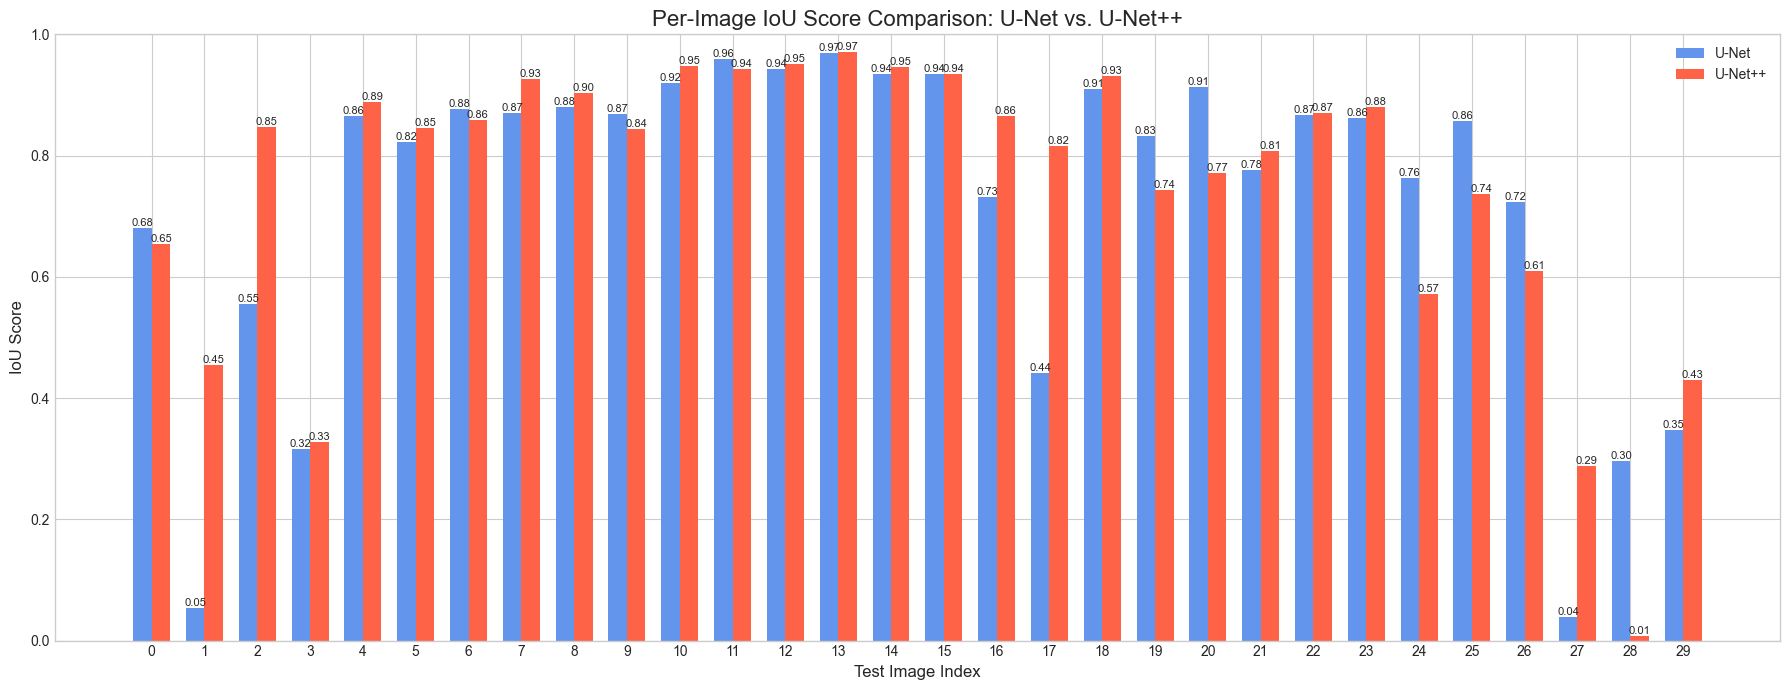

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# evaluate_model 함수를 개별 점수 리스트를 반환하도록 수정
def evaluate_model_and_get_scores(model, dataloader, device):
    model.eval()
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            preds = (outputs > 0.5).cpu().numpy().astype(np.uint8)
            targets_np = targets.cpu().numpy().astype(np.uint8)

            for i in range(preds.shape[0]):
                pred = preds[i].squeeze()
                target = targets_np[i].squeeze()

                iou_scores.append(calculate_iou_score_eval(target, pred))
                dice_scores.append(calculate_dice_score(target, pred))

    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)

    return avg_iou, avg_dice, iou_scores

# --- 평가 실행 및 점수 리스트 저장 ---
print("Evaluating U-Net to get per-image scores...")
, , unet_iou_scores = evaluate_model_and_get_scores(model_unet, test_loader, device)

print("Evaluating U-Net++ to get per-image scores...")
, , unet_pp_iou_scores = evaluate_model_and_get_scores(model_unet_plus_plus, test_loader, device)

# --- 차트 생성 ---
num_images = len(unet_iou_scores)
image_indices = np.arange(num_images)

plt.style.use('seaborn-v0_8-whitegrid') # 차트 스타일 설정
fig, ax = plt.subplots(figsize=(18, 7))

bar_width = 0.35
bar_unet = ax.bar(image_indices - bar_width/2, unet_iou_scores, bar_width, label='U-Net', color='cornflowerblue')
bar_unet_pp = ax.bar(image_indices + bar_width/2, unet_pp_iou_scores, bar_width, label='U-Net++', color='tomato')

# 차트 제목 및 레이블 설정
ax.set_title('Per-Image IoU Score Comparison: U-Net vs. U-Net++', fontsize=16)
ax.set_xlabel('Test Image Index', fontsize=12)
ax.set_ylabel('IoU Score', fontsize=12)
ax.set_xticks(image_indices)
ax.set_xticklabels(image_indices)
ax.legend()

# y축 범위를 0.0에서 1.0으로 설정
ax.set_ylim(0, 1.0)

# 막대 위에 값 표시 (옵션)
for bar in bar_unet:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=8)
for bar in bar_unet_pp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=8)


fig.tight_layout()
plt.show()

각 데이터별로 어떤 차이가 있는지 확인하기 위해 각 IoU 접수를 확인해 보았다.

확인 결과 큰 차이가 나는 이미지는 1,2,16,17,24,25,26,27,28,29번 임을 확인했다.

그중 U-Net++의 성능이 유독 높은 것은 1,2,17,27
U-net의 성능이 높은 유독 높은 것은 24,25,26,28로 이들의 데이터를 비교해 보고 싶다.

## 정성적 평가 (Qualitative Evaluation)
테스트 데이터셋의 특정 이미지를 골라, (1) 원본 이미지, (2) 실제 정답, (3) U-Net 예측, (4) U-Net++ 예측을
나란히 시각화하여 두 모델이 어떻게 다르게 예측하는지 확인해보자

랜덤으로 뽑아서 보면 위와 같이 

In [50]:
import matplotlib.pyplot as plt

def visualize_predictions(unet_model, unet_pp_model, dataset, device, sample_indices):
    """
    지정된 인덱스(sample_indices)의 샘플들에 대해 예측 결과를 시각화합니다.

    :param unet_model: U-Net 모델
    :param unet_pp_model: U-Net++ 모델
    :param dataset: 테스트 데이터셋
    :param device: 'cuda' 또는 'cpu'
    :param sample_indices: 비교할 이미지의 인덱스를 담은 리스트 (e.g., [5, 18, 29])
    """
    unet_model.eval()
    unet_pp_model.eval()

    for i in sample_indices:
        # 데이터셋의 크기를 초과하는 인덱스는 건너뜁니다.
        if i >= len(dataset):
            print(f"Warning: Index {i} is out of bounds for the dataset (size: {len(dataset)}). Skipping.")
            continue

        input_tensor, target_tensor = dataset[i]

        # 모델 입력을 위해 배치 차원 추가 및 디바이스로 이동
        input_batch = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            # U-Net 예측
            output_unet = unet_model(input_batch)
            pred_unet = (output_unet > 0.5).cpu().numpy().squeeze()

            # U-Net++ 예측
            output_unet_pp = unet_pp_model(input_batch)
            pred_unet_pp = (output_unet_pp > 0.5).cpu().numpy().squeeze()

        # 시각화를 위해 텐서 변환
        original_image = input_tensor.permute(1, 2, 0).cpu().numpy()
        ground_truth = target_tensor.squeeze().cpu().numpy()

        # 결과 시각화
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(original_image)
        axes[0].set_title(f"Original Image (Sample #{i})")
        axes[0].axis('off')

        axes[1].imshow(ground_truth, cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')

        axes[2].imshow(pred_unet, cmap='gray')
        axes[2].set_title("U-Net Prediction")
        axes[2].axis('off')

        axes[3].imshow(pred_unet_pp, cmap='gray')
        axes[3].set_title("U-Net++ Prediction")
        axes[3].axis('off')

        plt.show()

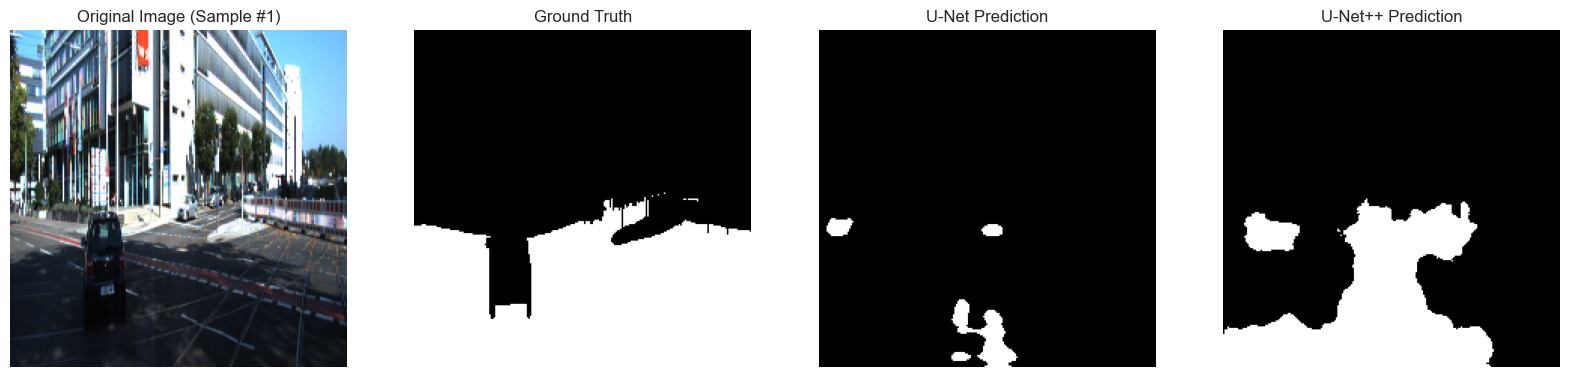

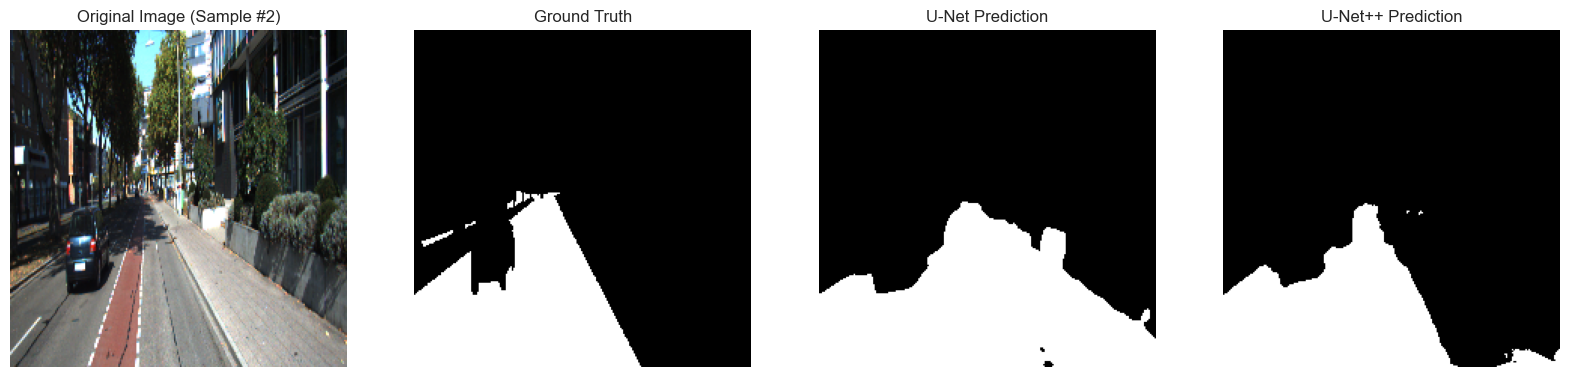

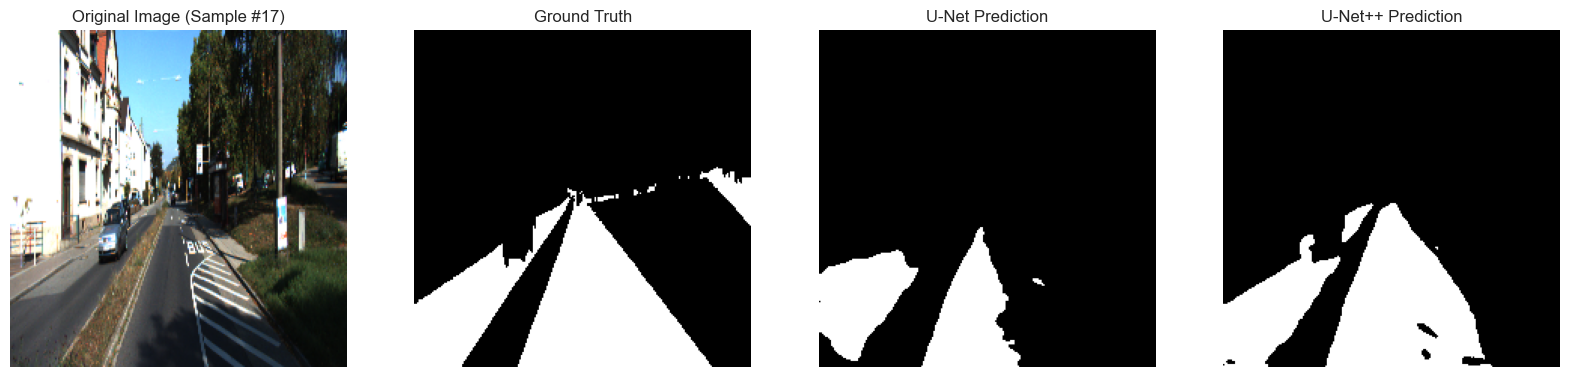

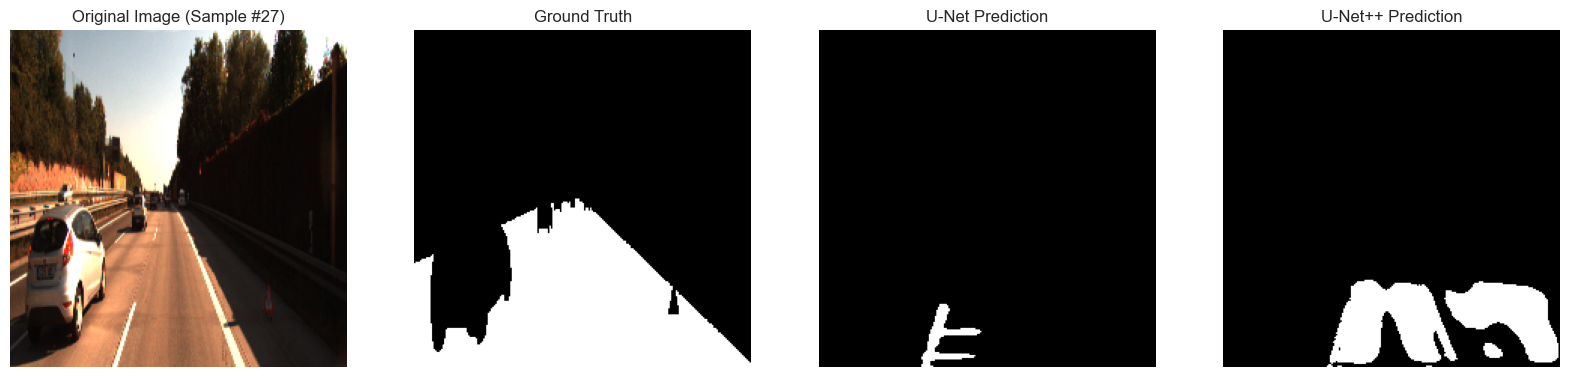

In [52]:
# --- 시각화 실행 (사용 예시) ---

# 1. 비교하고 싶은 테스트 이미지의 인덱스를 리스트로 정의합니다.
#    (test_dataset은 30개의 샘플을 가지고 있으므로 0~29 사이의 값을 선택)
specific_indices_to_compare = [1, 2, 17, 27]  # 예시 인덱스

# 2. 수정된 함수를 호출합니다.
visualize_predictions(
    model_unet,
    model_unet_plus_plus,
    test_dataset,
    device,
    sample_indices=specific_indices_to_compare
)

U-Net이 비교적 떨어지는 이미지의 경우 명확한 이유를 찾기 어려운 경우가 많이 있다.

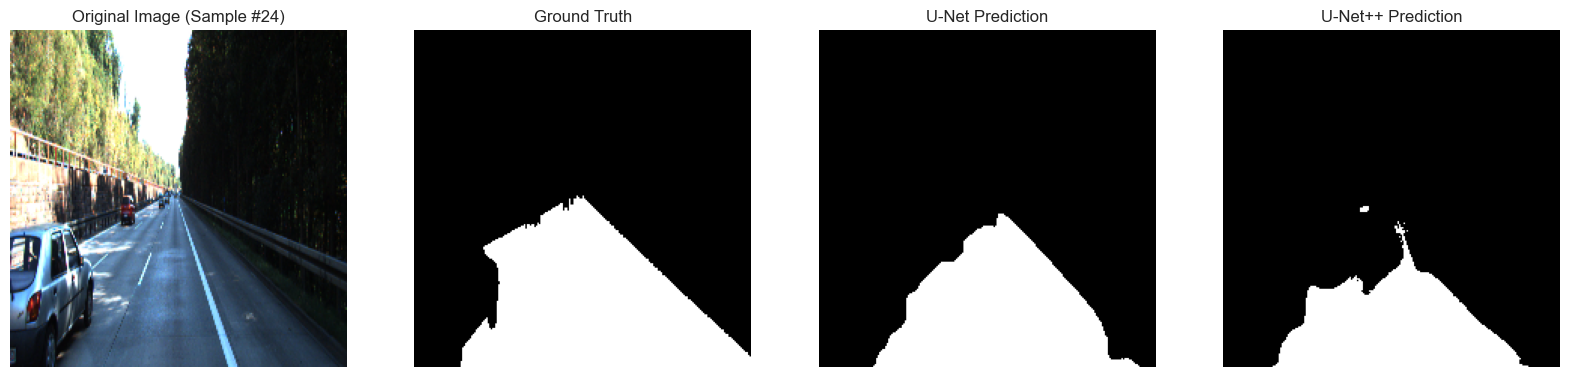

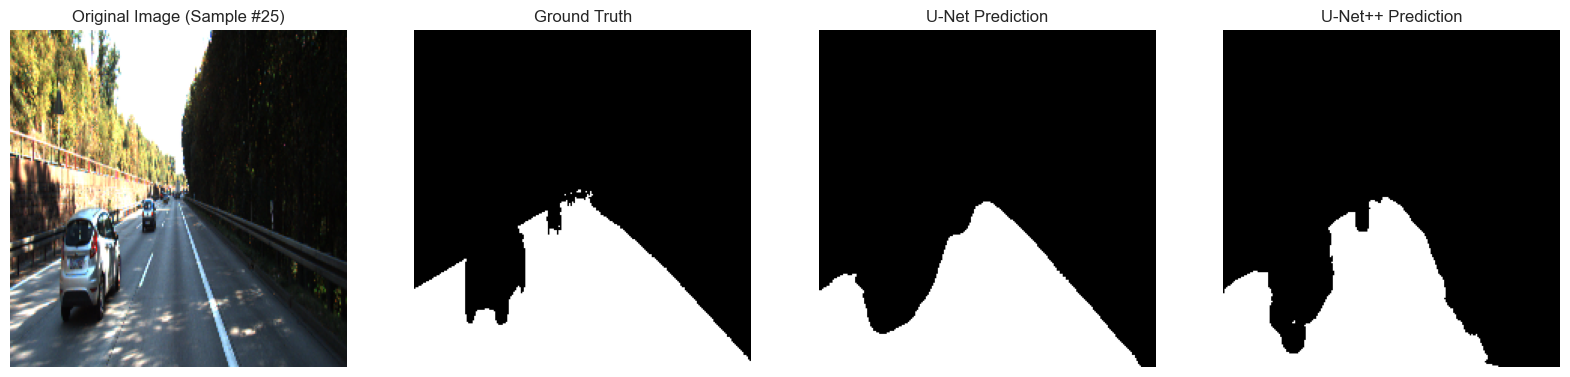

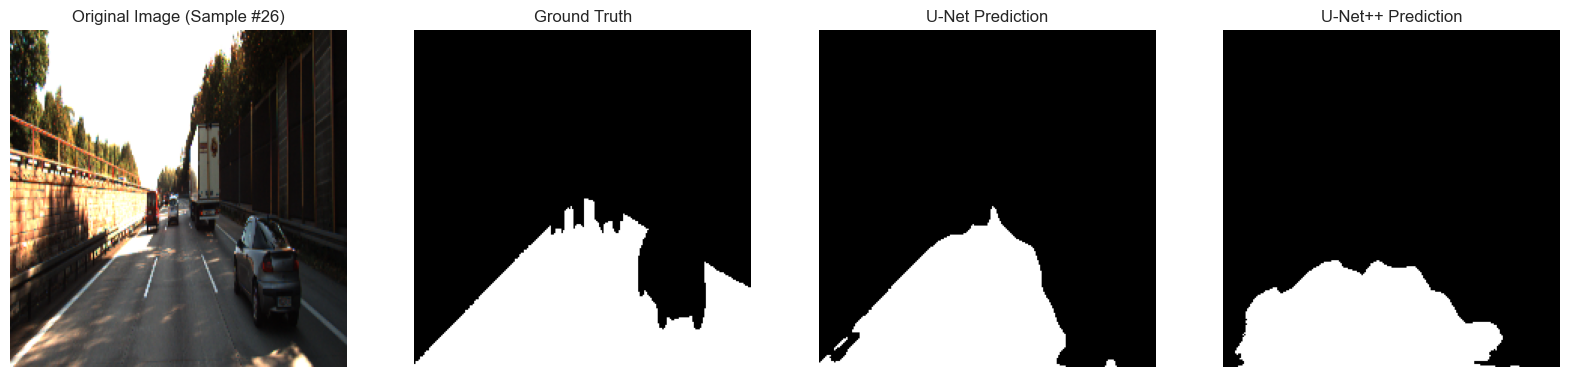

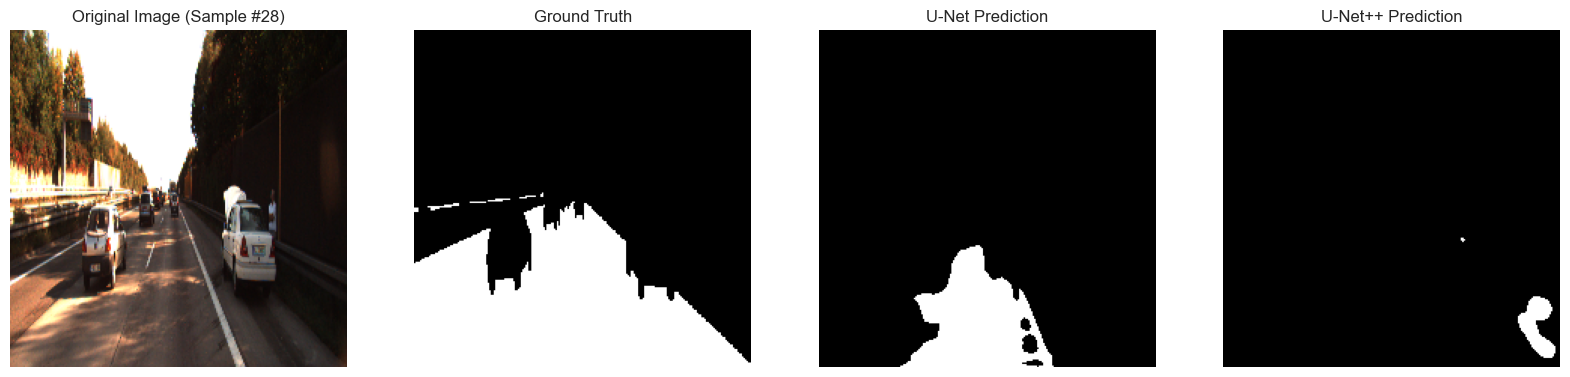

In [53]:
specific_indices_to_compare = [24,25,26,28]  # 예시 인덱스

# 2. 수정된 함수를 호출합니다.
visualize_predictions(
    model_unet,
    model_unet_plus_plus,
    test_dataset,
    device,
    sample_indices=specific_indices_to_compare
)

U-net에 비해 U-net++가 떨어지는 이미지의 경우 도로에 그림자가 생겨 변화가 많은 경우에 발생하는 것을 알 수 있다.

# 회고
전반적으로 이번에는 학습 데이터가 많이 적어서 낮은 경향이 있는 것 같다. 총 데이터가 200개 정도 밖에 안되니 어쩔 수 없는 것이 아닐까? 더 많은 데이터를 학습하면 좀더 잘 구분할 수 있을지 얼마나 많아야 좋을지 궁금하지만 또 너무 많으면 비용이 너무 커질 것 같아 도전해 보지는 못하겠다.